### AirBnB Price Prediction
- C14210085 Vincent Carel
- C14210109 Ella Arminta
- C14210225 Florentina Audrina

### Setting up environment

In [1]:
# https://brilliantprogrammer.medium.com/pyspark-random-forest-regression-machine-learning-a-practical-approach-part-7-459ffff42b8b
#importing required libs
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,VectorIndexer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql import Window
from pyspark.sql.functions import *

In [3]:
spark = (SparkSession.builder
         .appName('myApp')
         .master('local[*]')
         .getOrCreate()
        )
sc = spark.sparkContext 

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52019)
Traceback (most recent call last):
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\site-

### Reading the data

In [7]:
df = spark.read.format('csv').options(header=True, inferSchema=True, sep=',', quote='"', escape='"').load('train.csv')

df_with_id = df.withColumn("unique_id", monotonically_increasing_id())
print(df_with_id.count())
dfcol1 = df_with_id.select("unique_id", *df.columns[:10])
dfcol1.show()
dfcol2 = df_with_id.select("unique_id", *df.columns[10:19])
dfcol2.show()
dfcol3 = df_with_id.select("unique_id", *df.columns[19:27])
dfcol3.show()
dfcol4 = df_with_id.select("unique_id", *df.columns[27:])
dfcol4.show()

print('dfcol1',dfcol1.count())
print('dfcol2',dfcol2.count())
print('dfcol3',dfcol3.count())
print('dfcol4',dfcol4.count())


df_with_id.printSchema()

74113
+---------+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+
|unique_id|      id|         log_price|property_type|      room_type|           amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|
+---------+--------+------------------+-------------+---------------+--------------------+------------+---------+--------+-------------------+------------+
|        0| 6901257| 5.010635294096256|    Apartment|Entire home/apt|{"Wireless Intern...|           3|      1.0|Real Bed|             strict|        true|
|        1| 6304928|5.1298987149230735|    Apartment|Entire home/apt|{"Wireless Intern...|           7|      1.0|Real Bed|             strict|        true|
|        2| 7919400| 4.976733742420574|    Apartment|Entire home/apt|{TV,"Cable TV","W...|           5|      1.0|Real Bed|           moderate|        true|
|        3|13418779| 6.620073206530356|        House|Entir

#### Try to process amenities

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import split

# Define the UDF to process amenities
def process_amenities(amenities):
    amenities = amenities.replace('"', '').replace('{', '').replace('}', '').split(',')
    amenities = [amenity.strip() for amenity in amenities if amenity.strip() and 
                 amenity.strip() not in ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50']]
    return amenities

process_amenities_udf = udf(process_amenities, ArrayType(StringType()))
# # Apply the UDF to the amenities column
dfcol1 = dfcol1.withColumn("amenities_list", process_amenities_udf(col("amenities")))
dfcol1.select(['id','amenities_list']).show()

# Flatten the amenities list column
# exploded_df = dfcol1.withColumn("amenity", explode(col("amenities_list")))
# # Count the occurrences of each amenity
# amenity_counts = exploded_df.groupBy("amenity").count()
# # Get the top 10 most frequent amenities
# top_amenities = amenity_counts.orderBy(col("count").desc()).limit(10)
# top_amenities.show()


# Step 1: Flatten the amenities_list column and compute top 10 amenities
try:
    top_amenities = dfcol1.select(explode("amenities_list").alias("amenity")) \
                      .groupBy("amenity") \
                      .count() \
                      .orderBy(col("count").desc()) \
                      .limit(10) \
                      .select("amenity") \
                      .rdd.flatMap(lambda x: x).collect()
    print(top_amenities)
except Exception as e:
    print(f"Error occurred: {e}")

+--------+--------------------+
|      id|      amenities_list|
+--------+--------------------+
| 6901257|[Wireless Interne...|
| 6304928|[Wireless Interne...|
| 7919400|[TV, Cable TV, Wi...|
|13418779|[TV, Cable TV, In...|
| 3808709|[TV, Internet, Wi...|
|12422935|[TV, Wireless Int...|
|11825529|[TV, Internet, Wi...|
|13971273|[TV, Cable TV, Wi...|
|  180792|[TV, Cable TV, Wi...|
| 5385260|[Wireless Interne...|
| 5578513|[Internet, Wirele...|
|17423675|[TV, Cable TV, In...|
|14066228|[TV, Internet, Wi...|
| 2658946|[TV, Cable TV, In...|
|  583490|[Kitchen, Heating...|
| 6226658|[Internet, Wirele...|
| 7499179|[TV, Wireless Int...|
|14648556|[Internet, Wirele...|
|17589436|[TV, Cable TV, In...|
|18224863|[TV, Wireless Int...|
+--------+--------------------+
only showing top 20 rows

Error occurred: An error occurred while calling o125.javaToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 22.0 failed 1 times, most recent failure: Lost task 3.

In [194]:
dfcol1 = dfcol1.drop('amenities_list', 'amenities')
dfcol1.show()

+---------+--------+------------------+-------------+---------------+------------+---------+--------+-------------------+------------+
|unique_id|      id|         log_price|property_type|      room_type|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|
+---------+--------+------------------+-------------+---------------+------------+---------+--------+-------------------+------------+
|        0| 6901257| 5.010635294096256|    Apartment|Entire home/apt|           3|      1.0|Real Bed|             strict|        true|
|        1| 6304928|5.1298987149230735|    Apartment|Entire home/apt|           7|      1.0|Real Bed|             strict|        true|
|        2| 7919400| 4.976733742420574|    Apartment|Entire home/apt|           5|      1.0|Real Bed|           moderate|        true|
|        3|13418779| 6.620073206530356|        House|Entire home/apt|           4|      1.0|Real Bed|           flexible|        true|
|        4| 3808709|  4.74493212836325|    Apartment|En

### Cleaning Data - Replace Null Value

In [8]:
# Missing Value
columns_to_check = [c for c in dfcol1.columns if c not in  ['cleaning_fee','first_review','host_since','last_review']]
# df.select([count(when(col(c).isNull() | isnan(c), 1)).alias(c) for c in columns_to_check]).show(vertical=True)
# dftemp = df.select(['cleaning_fee','first_review','host_since','last_review'])

# dftemp.select([count(when(col(c).isNull(), 1)).alias(c) for c in dftemp.columns]).show()

dfcol1.select([count(when(col(c).isNull() | isnan(c), 1)).alias(c) for c in columns_to_check]).show(vertical=True)
dfcol1.printSchema()

-RECORD 0------------------
 unique_id           | 0   
 id                  | 0   
 log_price           | 0   
 property_type       | 0   
 room_type           | 2   
 amenities           | 2   
 accommodates        | 2   
 bathrooms           | 202 
 bed_type            | 2   
 cancellation_policy | 2   

root
 |-- unique_id: long (nullable = false)
 |-- id: string (nullable = true)
 |-- log_price: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- amenities: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)



#### Clean dfcol1

In [9]:
dfcol1.select([count(when(col(c).isNull(), 1)).alias(c) for c in dfcol1.columns]).show()

# mereplace null value bathroom
dfcol1bathrooms = dfcol1 \
    .groupBy(['property_type', 'room_type', 'accommodates', 'bathrooms']) \
    .agg(count('bathrooms').alias('bathroom_count')) \
    .sort('property_type', 'room_type', 'accommodates')

# delete row dimana bathroom null
dfcol1bathrooms = dfcol1bathrooms.dropna(subset=['bathrooms'])

# max bathroom count per groupby
max_bathroom_count_df = dfcol1bathrooms \
    .groupBy(['property_type', 'room_type', 'accommodates']) \
    .agg(max('bathroom_count').alias('max_bathroom_count'))

# join database bathrooms dengan max bathrooms
dfcol1bathrooms = dfcol1bathrooms \
    .join(max_bathroom_count_df, on=['property_type', 'room_type', 'accommodates'], how="left") \
    .filter(dfcol1bathrooms['bathroom_count'] == max_bathroom_count_df['max_bathroom_count']) \
    .drop('max_bathroom_count')

# distinct dalam dfcol1bathrooms
dfcol1bathrooms = dfcol1bathrooms.withColumn('bathrooms_predicted', col('bathrooms'))
dfcol1bathrooms = dfcol1bathrooms.groupBy(['property_type', 'room_type', 'accommodates','bathroom_count']).agg(count('bathroom_count').alias('count_row'), avg(col('bathrooms_predicted')).alias('avg_bathrooms_predicted'))
dfcol1bathrooms = dfcol1bathrooms.drop('bathrooms')
print('dfcol1bathrooms',dfcol1bathrooms.count())
dfcol1bathrooms.show()

# replace null value bathrooms sm dfcol1bathrooms
print('dfcol1 1',dfcol1.count())
dftemp = dfcol1.join(dfcol1bathrooms, on=['property_type', 'room_type', 'accommodates'], how='left')
print('dftemp1',dftemp.count())
# dftemp.show()
dftemp = dftemp.withColumn(
    'bathrooms',
    when(col('bathrooms').isNull(), col('avg_bathrooms_predicted')).otherwise(col('bathrooms'))
)

dftemp = dftemp.drop('avg_bathrooms_predicted','bathroom_count','count_row')
dftemp = dftemp.filter(dftemp['bathrooms'].isNotNull())
dftemp.where(dftemp['bathrooms'].isNull()).show()
dftemp.select([count(when(col(c).isNull(), 1)).alias(c) for c in dftemp.columns]).show()

print('dftemp2',dftemp.count())
dfcol1 = dftemp
dfcol1.drop('amenities')
dfcol1.show()
print(dfcol1.count())

+---------+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+
|unique_id| id|log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|
+---------+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+
|        0|  0|        0|            0|        2|        2|           2|      202|       2|                  2|           2|
+---------+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+

dfcol1bathrooms 451
+--------------+---------------+------------+--------------+---------+-----------------------+
| property_type|      room_type|accommodates|bathroom_count|count_row|avg_bathrooms_predicted|
+--------------+---------------+------------+--------------+---------+-----------------------+
|        Hostel|    Shared room|           4|             1|        2

In [197]:
dfcol1.select([count(when(col(c).isNull() | isnan(c), 1)).alias(c) for c in columns_to_check]).show(vertical=True)

-RECORD 0------------------
 unique_id           | 0   
 id                  | 0   
 log_price           | 0   
 property_type       | 0   
 room_type           | 0   
 accommodates        | 0   
 bathrooms           | 0   
 bed_type            | 0   
 cancellation_policy | 0   



#### Preprocess dfcol1

In [10]:
# dfcol1.show()
dfcol1.printSchema()
dfcol1 = dfcol1.drop(*['id','amenities'])
dfcol1 = dfcol1.withColumn('cleaning_fee_idx', when(col('cleaning_fee') == 'true', 1).otherwise(0))
dfcol1 = dfcol1.withColumn('cancellation_policy_idx', when(col('cancellation_policy') == 'flexible', 0).otherwise(when(col('cancellation_policy') == 'moderate', 1).otherwise(2)))
dfcol1.printSchema()
dfcol1.show()

root
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- id: string (nullable = true)
 |-- log_price: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)

root
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- unique_id: long (nullable = false)
 |-- log_price: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: boolean (nullable = true)
 |-- cleaning_fee_idx: integer (nullable = false)
 |-- cancellation_policy_idx: integer (nullable = false)

+---------------+-----------

In [11]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(dfcol1) for col in ['property_type','room_type','bed_type']]
pipeline = Pipeline(stages=indexers)
dfcol1 = pipeline.fit(dfcol1).transform(dfcol1)
dfcol1.show()

+---------------+---------------+------------+---------+------------------+---------+--------+-------------------+------------+----------------+-----------------------+-----------------+-------------+------------+
|  property_type|      room_type|accommodates|unique_id|         log_price|bathrooms|bed_type|cancellation_policy|cleaning_fee|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|
+---------------+---------------+------------+---------+------------------+---------+--------+-------------------+------------+----------------+-----------------------+-----------------+-------------+------------+
|         Hostel|   Private room|           3|     1629| 4.700480365792417|      1.0|Real Bed|           flexible|       false|               0|                      0|             16.0|          1.0|         0.0|
|Bed & Breakfast|    Shared room|           2|     1152|4.0943445622220995|      1.0|Real Bed|           flexible|        true|               1|

In [12]:
dfcol1 = dfcol1.select(['unique_id','log_price','accommodates','bathrooms','cleaning_fee_idx','cancellation_policy_idx','property_type_idx','room_type_idx','bed_type_idx'])
dfcol1.show()

+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+
|unique_id|         log_price|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+
|     1629| 4.700480365792417|           3|      1.0|               0|                      0|             16.0|          1.0|         0.0|
|     1152|4.0943445622220995|           2|      1.0|               1|                      0|              7.0|          2.0|         0.0|
|     4675| 4.330733340286331|           2|      1.0|               0|                      2|              7.0|          2.0|         0.0|
|     7111|  4.23410650459726|           2|      0.0|               0|                      0|              7.0|          2.0|         0.0|
|      181| 4.941642

#### Clean dfcol2 & Preprocess

In [13]:
# dfcol2
# column list:
# city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review

# column tambahan: years_as_host,city_idx
# column yang didrop: city, first_review, host_since, last_review
# preprocessing
# 1
# Convert 't' to 1 and 'f' to 0
dfcol2 = dfcol2.withColumn('host_has_profile_pic', when(col('host_has_profile_pic') == 't', 1).otherwise(0))
dfcol2 = dfcol2.withColumn('host_identity_verified', when(col('host_identity_verified') == 't', 1).otherwise(0))
dfcol2 = dfcol2.withColumn('instant_bookable', when(col('instant_bookable') == 't', 1).otherwise(0))
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|              NULL|2012-03-26|               0| 2016-07-18|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|              100%|2017-06-19|               1| 2017-09-23|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|              100%|2016-10-25|               1| 2017-09-14|
|        3|     SF|This light-filled...|        NULL|     

In [14]:
# 2
# Convert host_response_rate to float
dfcol2 = dfcol2.withColumn('host_response_rate', 
                   regexp_replace('host_response_rate', '%', '').cast('float') / 100)

# Calculate the average host_response_rate
average_rate = dfcol2.select(avg(col('host_response_rate'))).collect()[0][0]

# Fill null values with the average rate
dfcol2 = dfcol2.withColumn('host_response_rate', when(col('host_response_rate').isNull(), average_rate).otherwise(col('host_response_rate')))
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|0.9435196731885569|2012-03-26|               0| 2016-07-18|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|               1.0|2017-06-19|               1| 2017-09-23|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|               1.0|2016-10-25|               1| 2017-09-14|
|        3|     SF|This light-filled...|        NULL|     

In [15]:
# 3
# Get the current year
current_year = 2024

# Extract the year from 'host_since' and calculate 'years_as_host'
dfcol2 = dfcol2.withColumn('years_as_host', current_year - year(col('host_since')))

In [16]:
# 4
# fill misssing values for CITY

dfcol2 = dfcol2.fillna({'city' : 'NYC'})
dfcol2.show()

+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-------------+
|unique_id|   city|         description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|years_as_host|
+---------+-------+--------------------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+-------------+
|        0|    NYC|Beautiful, sunlit...|  2016-06-18|                   1|                     1|0.9435196731885569|2012-03-26|               0| 2016-07-18|           12|
|        1|    NYC|Enjoy travelling ...|  2017-08-05|                   1|                     0|               1.0|2017-06-19|               1| 2017-09-23|            7|
|        2|    NYC|The Oasis comes c...|  2017-04-30|                   1|                     1|               1.0|2016-10-25|               1| 

In [17]:
# 5
dfcol2 = dfcol2.drop('description','first_review', 'host_since', 'last_review')

In [18]:
# 6
# changing city to numerical
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df) for col in ['city']]

pipeline = Pipeline(stages=indexers) #optional
dfcol2 = pipeline.fit(dfcol2).transform(dfcol2).drop('city')
dfcol2.show()

+---------+--------------------+----------------------+------------------+----------------+-------------+--------+
|unique_id|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|
+---------+--------------------+----------------------+------------------+----------------+-------------+--------+
|        0|                   1|                     1|0.9435196731885569|               0|           12|     0.0|
|        1|                   1|                     0|               1.0|               1|            7|     0.0|
|        2|                   1|                     1|               1.0|               1|            8|     0.0|
|        3|                   1|                     1|0.9435196731885569|               0|            9|     2.0|
|        4|                   1|                     1|               1.0|               1|            9|     3.0|
|        5|                   1|                     1|               1.0|      

#### DFCOL 3 & 4

In [19]:
dfcol3.show()
dfcol4.show()
dfcol3.printSchema()
dfcol4.printSchema()

+---------+------------------+-------------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+
|unique_id|          latitude|          longitude|                name|    neighbourhood|number_of_reviews|review_scores_rating|       thumbnail_url|zipcode|
+---------+------------------+-------------------+--------------------+-----------------+-----------------+--------------------+--------------------+-------+
|        0|40.696523629970756| -73.99161684624262|Beautiful brownst...| Brooklyn Heights|                2|               100.0|https://a0.muscac...|  11201|
|        1|40.766115415949685| -73.98903992265213|Superb 3BR Apt Lo...|   Hell's Kitchen|                6|                93.0|https://a0.muscac...|  10019|
|        2| 40.80810998936211| -73.94375584395794|    The Garden Oasis|           Harlem|               10|                92.0|https://a0.muscac...|  10027|
|        3|37.772004482560774|-122.43161868239788|Be

In [20]:
dfcol3 = dfcol3.drop('name','thumbnail_url')
dfcol3.show()
dfcol4.show()

+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|    neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|        0|40.696523629970756| -73.99161684624262| Brooklyn Heights|                2|               100.0|  11201|
|        1|40.766115415949685| -73.98903992265213|   Hell's Kitchen|                6|                93.0|  10019|
|        2| 40.80810998936211| -73.94375584395794|           Harlem|               10|                92.0|  10027|
|        3|37.772004482560774|-122.43161868239788|     Lower Haight|                0|                NULL|94117.0|
|        4|38.925626916626506|  -77.0345955156553| Columbia Heights|                4|                40.0|  20009|
|        5|  37.7531640472884| -122.4295260773271|       Noe Valley|    

In [21]:
# check is null
dfcol3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcol3.columns]).show()
dfcol4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcol4.columns]).show()
dfcol3.where(col('neighbourhood').isNull()).show()
dfcol4.where(col('beds').isNull()).show()



+---------+--------+---------+-------------+-----------------+--------------------+-------+
|unique_id|latitude|longitude|neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+--------+---------+-------------+-----------------+--------------------+-------+
|        0|       2|        2|         6874|                2|               16724|    968|
+---------+--------+---------+-------------+-----------------+--------------------+-------+

+---------+--------+----+
|unique_id|bedrooms|beds|
+---------+--------+----+
|        0|      95| 135|
+---------+--------+----+

+---------+------------------+-------------------+-------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-------------+-----------------+--------------------+-------+
|        6|33.980454397275096|-118.46282073746792|         NULL|        

In [22]:
# replace null value in neighbourhood
dfcol3.where(col('neighbourhood').isNull()).show()
dfcol3 = dfcol3.fillna("Dunno", subset=["neighbourhood"])
dfcol3.show()

+---------+------------------+-------------------+-------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-------------+-----------------+--------------------+-------+
|        6|33.980454397275096|-118.46282073746792|         NULL|               15|                97.0|  90292|
|        9| 33.99256298219745|-117.89599660615322|         NULL|                2|                90.0|  91748|
|       14|33.778526474548066|-118.14592576139098|         NULL|                2|               100.0|  90804|
|       26|34.100686487326065| -118.3642035832992|         NULL|                1|               100.0|   NULL|
|       28| 34.05158404571294|-118.24292308604038|         NULL|                4|                95.0|  90028|
|       34|34.086308571477765|-118.27122668161104|         NULL|                1|                NULL| 

In [23]:
# dfcol3 replace null latitude longitude, number of reviews, review_scores_rating, zipcode
# latitude
dfcol3temp = dfcol3
dfcol3temp.show()
dfcol3temp = dfcol3temp.fillna(0, subset=["latitude"])

# longitude
dfcol3temp = dfcol3temp.fillna(0, subset=["longitude"])

# review_scores_rating
dfcol3temp = dfcol3temp.fillna(0, subset=["review_scores_rating"])

# zipcode
dfcol3temp.withColumn('zipcode', col('zipcode').cast('integer'))
# dfcol3temp.where(col('zipcode').isNull()).show()
dfcol3temp = dfcol3temp.withColumn('zipcode', when(col('zipcode').isNull(), 0).otherwise(col('zipcode')))

# num_reviews
dfcol3temp.withColumn('number_of_reviews', col('number_of_reviews').cast('integer'))
dfcol3temp.where(col('number_of_reviews').isNull()).show()
dfcol3temp = dfcol3temp.withColumn('number_of_reviews', when(col('number_of_reviews').isNull(), 0).otherwise(col('number_of_reviews')))
dfcol3temp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcol3temp.columns]).show()

# dfcol4 replace null bedrooms|beds
# bedrooms
dfcol4temp = dfcol4
# dfcol4temp = dfcol4temp.
dfcol4temp = dfcol4temp.fillna(0, subset=["bedrooms"])


+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|    neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|        0|40.696523629970756| -73.99161684624262| Brooklyn Heights|                2|               100.0|  11201|
|        1|40.766115415949685| -73.98903992265213|   Hell's Kitchen|                6|                93.0|  10019|
|        2| 40.80810998936211| -73.94375584395794|           Harlem|               10|                92.0|  10027|
|        3|37.772004482560774|-122.43161868239788|     Lower Haight|                0|                NULL|94117.0|
|        4|38.925626916626506|  -77.0345955156553| Columbia Heights|                4|                40.0|  20009|
|        5|  37.7531640472884| -122.4295260773271|       Noe Valley|    

In [24]:
# fillna(0, subset=["bedrooms"])

# beds
dfcol4temp = dfcol4temp.fillna(0, subset=["beds"])

dfcol4temp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcol4temp.columns]).show()

dfcol3temp.show()
dfcol4temp.show()

+---------+--------+----+
|unique_id|bedrooms|beds|
+---------+--------+----+
|        0|       0|   0|
+---------+--------+----+

+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|    neighbourhood|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|        0|40.696523629970756| -73.99161684624262| Brooklyn Heights|                2|               100.0|  11201|
|        1|40.766115415949685| -73.98903992265213|   Hell's Kitchen|                6|                93.0|  10019|
|        2| 40.80810998936211| -73.94375584395794|           Harlem|               10|                92.0|  10027|
|        3|37.772004482560774|-122.43161868239788|     Lower Haight|                0|                 0.0|94117.0|
|        4|38.925626916626506|  -77.0345955156553| Columb

In [25]:
# String Indexer
# dfcol3temp.show()
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(dfcol3temp) for col in ['neighbourhood']]

pipeline = Pipeline(stages=indexers)
dfcol3temp = pipeline.fit(dfcol3temp).transform(dfcol3temp)

# dfcol3temp.show()
# dfcol4temp.show()

dfcol3 = dfcol3temp.select(['unique_id','latitude','longitude','neighbourhood_idx','number_of_reviews','review_scores_rating','zipcode'])
dfcol4 = dfcol4temp.select(['unique_id','bedrooms','beds'])
dfcol3.show()
print(dfcol3.count())
dfcol4.show()
print(dfcol4.count())

+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|unique_id|          latitude|          longitude|neighbourhood_idx|number_of_reviews|review_scores_rating|zipcode|
+---------+------------------+-------------------+-----------------+-----------------+--------------------+-------+
|        0|40.696523629970756| -73.99161684624262|            151.0|                2|               100.0|  11201|
|        1|40.766115415949685| -73.98903992265213|              8.0|                6|                93.0|  10019|
|        2| 40.80810998936211| -73.94375584395794|              6.0|               10|                92.0|  10027|
|        3|37.772004482560774|-122.43161868239788|            136.0|                0|                 0.0|94117.0|
|        4|38.925626916626506|  -77.0345955156553|             51.0|                4|                40.0|  20009|
|        5|  37.7531640472884| -122.4295260773271|             46.0|    

In [26]:
print(dfcol3.count())
print(dfcol4.count())

74113
74113


### DF Final

In [27]:
print('dfcol1',dfcol1.count())
print('dfcol2',dfcol2.count())
print('dfcol2',dfcol3.count())
print('dfcol2',dfcol4.count())

dfcolfinal = dfcol1.join(dfcol2, on="unique_id", how="inner") \
                   .join(dfcol3, on="unique_id", how="inner") \
                   .join(dfcol4, on="unique_id", how="inner") \

print('dfcolfinal',dfcolfinal.count())
# intersection_ids = dfcol1.select("unique_id") \
#     .intersect(dfcol2.select("unique_id")) \
#     # .intersect(dfcol3.select("unique_id")) \
#     # .intersect(dfcol4.select("unique_id"))

# # Filter the original DataFrame with these intersection IDs
# dfcolfinal = df_with_id.join(intersection_ids, on="unique_id").drop("unique_id")

# Show the final DataFrame
dfcolfinal.show()

dfcol1 74110
dfcol2 74113
dfcol2 74113
dfcol2 74113
dfcolfinal 74110
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+------------------+-------------------+-----------------+-----------------+--------------------+-------+--------+----+
|unique_id|         log_price|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|          latitude|          longitude|neighbourhood_idx|number_of_reviews|review_scores_rating|zipcode|bedrooms|beds|
+---------+------------------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+-------

In [28]:
dfcolfinal = dfcolfinal.withColumn('zipcode', col('zipcode').cast('integer'))
dfcolfinal.printSchema()

root
 |-- unique_id: long (nullable = false)
 |-- log_price: double (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- cleaning_fee_idx: integer (nullable = false)
 |-- cancellation_policy_idx: integer (nullable = false)
 |-- property_type_idx: double (nullable = false)
 |-- room_type_idx: double (nullable = false)
 |-- bed_type_idx: double (nullable = false)
 |-- host_has_profile_pic: integer (nullable = false)
 |-- host_identity_verified: integer (nullable = false)
 |-- host_response_rate: double (nullable = true)
 |-- instant_bookable: integer (nullable = false)
 |-- years_as_host: integer (nullable = true)
 |-- city_idx: double (nullable = false)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)
 |-- neighbourhood_idx: double (nullable = false)
 |-- number_of_reviews: integer (nullable = true)
 |-- review_scores_rating: double (nullable = false)
 |-- zipcode: integer (nullable = true)
 |-- be

In [29]:
dfcolfinaltemp = dfcolfinal
# dfcolfinaltemp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcolfinal.columns]).show()
# replace null zipcode
# dfcolfinaltemp = dfcolfinaltemp.fillna('zipcode', if not null col('zipcode') else 0)
dfcolfinaltemp = dfcolfinaltemp.withColumn('zipcode', when(col('zipcode').isNull(), 0).otherwise(col('zipcode')))
dfcolfinaltemp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcolfinaltemp.columns]).show()

#replace null value in years_as_host
avg_years_as_host = dfcolfinaltemp.select(avg(col('years_as_host'))).collect()[0][0]
dfcolfinaltemp = dfcolfinaltemp.withColumn('years_as_host', when(col('years_as_host').isNull(), avg_years_as_host).otherwise(col('years_as_host')))
# Show the resulting DataFrame
dfcolfinaltemp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfcolfinaltemp.columns]).show()
dfcolfinal = dfcolfinaltemp

+---------+---------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+--------+---------+-----------------+-----------------+--------------------+-------+--------+----+
|unique_id|log_price|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|latitude|longitude|neighbourhood_idx|number_of_reviews|review_scores_rating|zipcode|bedrooms|beds|
+---------+---------+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+--------+---------+-----------------+-----------------+--------------------+-------+--------+----+
|   

## EDA

### Correlation Matrix

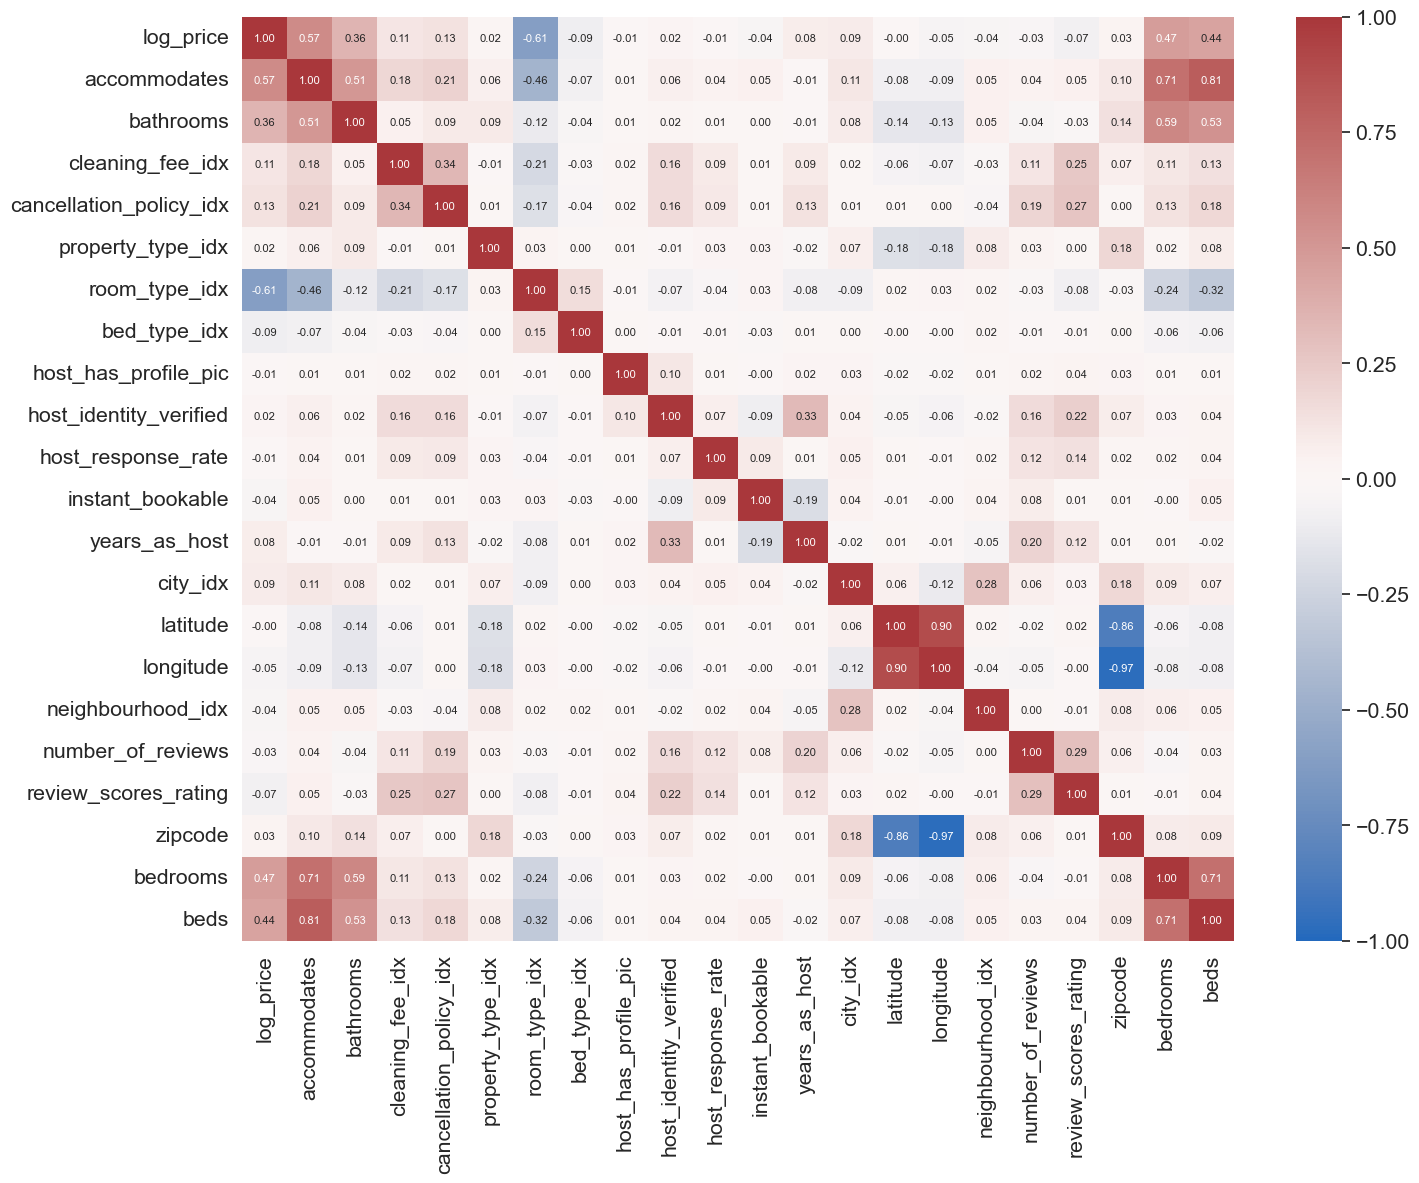

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

dfcolmatrix = dfcolfinal
dfcolmatrix = dfcolmatrix.drop('unique_id')
plt.figure(figsize=(16,12))
sns.set(font_scale=1.4)
heat = sns.heatmap(data=dfcolmatrix.toPandas().corr(), cmap='vlag', vmin=-1, vmax=1,annot=True,fmt=".2f", annot_kws={"size": 8})

### Chart Log price x room_type_idx

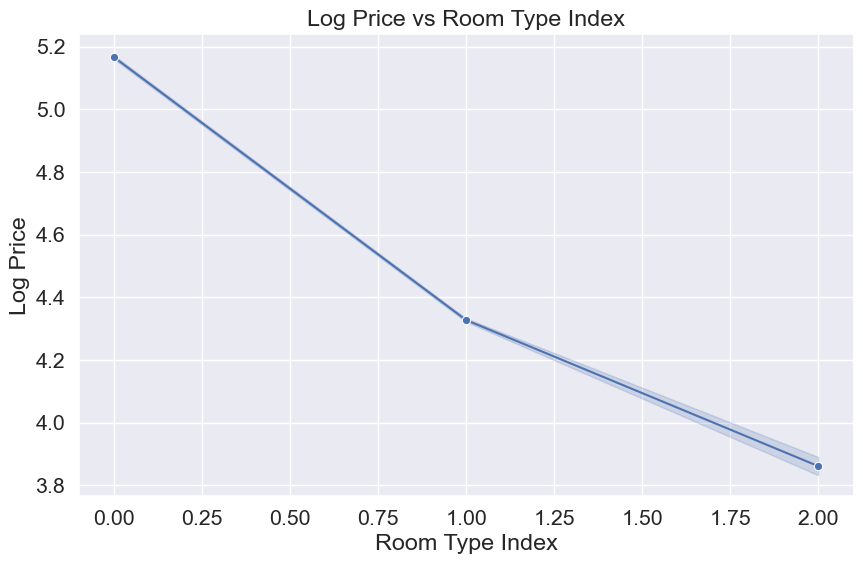

In [204]:
dflinechart = dfcolfinal.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=dflinechart, x='room_type_idx', y='log_price', marker='o')

plt.title('Log Price vs Room Type Index')
plt.xlabel('Room Type Index')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

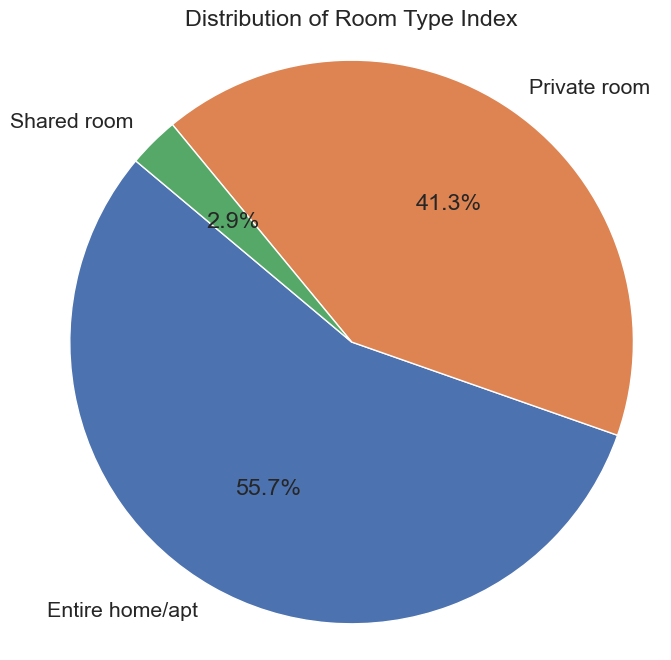

In [205]:
dfpiechartroom = dfcolfinal.toPandas()

# Count the occurrences of each unique room_type_idx
room_type_counts = dfpiechartroom['room_type_idx'].value_counts()

room_type_mapping = {
    0.0: 'Entire home/apt',
    1.0: 'Private room',
    2.0: 'Shared room',
    3.0: 'Hotel room',
}
room_type_labels = room_type_counts.index.map(room_type_mapping)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(room_type_counts, labels=room_type_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Room Type Index')
plt.axis('equal') 
plt.show()

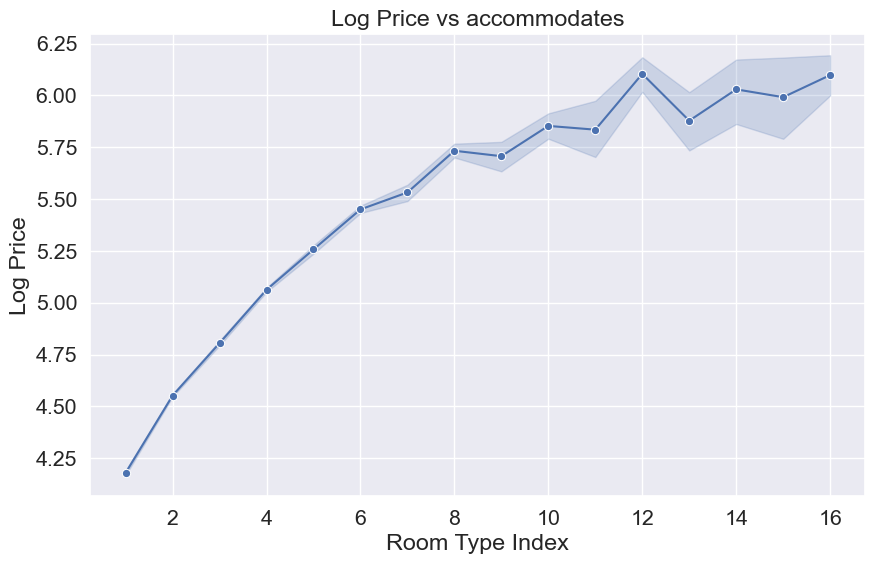

In [206]:
dflinechart = dfcolfinal.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=dflinechart, x='accommodates', y='log_price', marker='o')

plt.title('Log Price vs accommodates')
plt.xlabel('Room Type Index')
plt.ylabel('Log Price')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

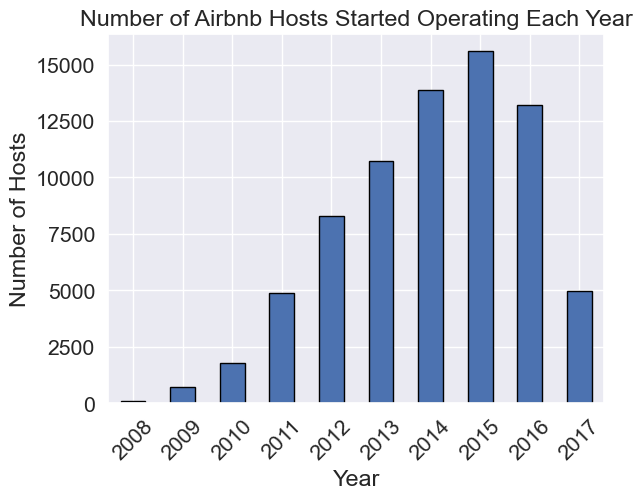

In [207]:
# Current year
current_year = 2024

# Calculate the start year
dfcolfinal_year = dfcolfinal.withColumn('start_year', current_year - col('years_as_host'))

# Drop rows with NaN values in start_year
dfcolfinal_year = dfcolfinal_year.dropna(subset=['start_year'])

# Convert start_year to integer type
dfcolfinal_year = dfcolfinal_year.withColumn('start_year', col('start_year').cast('integer'))

# Group by start_year and count the number of rows in each year
yearly_counts = dfcolfinal_year.groupBy('start_year').count()

# Convert the grouped data to a Pandas DataFrame
yearly_counts_pd = yearly_counts.orderBy('start_year').toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
yearly_counts_pd.plot(kind='bar', x='start_year', y='count', legend=False, edgecolor='black')
plt.title('Number of Airbnb Hosts Started Operating Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Hosts')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

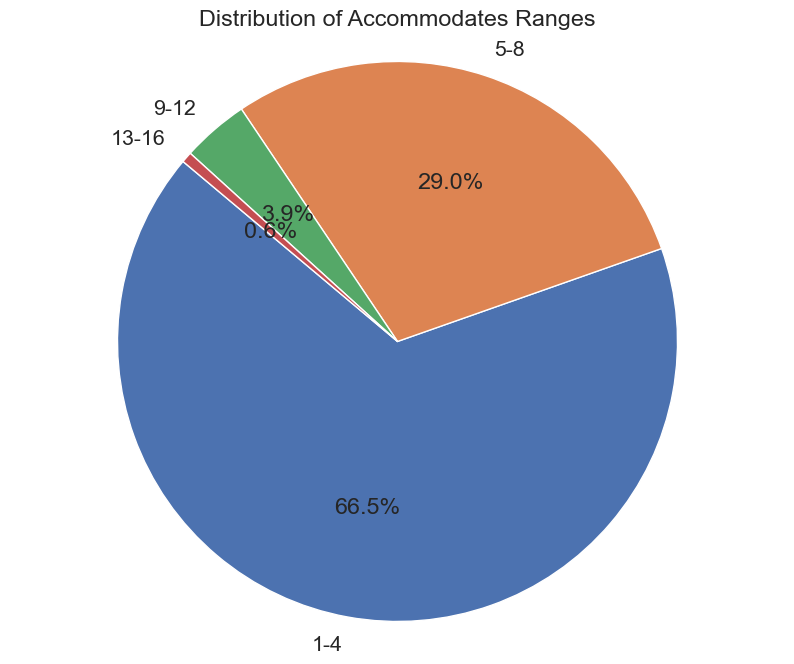

In [208]:
import pandas as pd
dfdistaccomodates = dfcolfinal.toPandas()

# Define the ranges for accommodates
bins = [0, 4, 8, 12, 16]
labels = ['1-4', '5-8', '9-12', '13-16']

# Create a new column 'accommodates_range' that groups accommodates into ranges
dfdistaccomodates['accommodates_range'] = pd.cut(dfdistaccomodates['accommodates'], bins=bins, labels=labels, right=False)

# Count the occurrences of each range
accommodates_counts = dfdistaccomodates['accommodates_range'].value_counts().sort_index()

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(accommodates_counts, labels=accommodates_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Accommodates Ranges')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

### Feature Selection

In [30]:
features = dfcolfinal
features = features.drop('log_price','unique_id','latitude')
# Train Data
# RMSE on train data = 0.374182
# MAE on train data = 0.273545
# R2 on train data = 0.727074
# MSE on train data = 0.140012
# Test Data
# RMSE on test data = 0.417308
# MAE on test data = 0.303604
# R2 on test data = 0.665915
# MSE on test data = 0.174146
# GBTRegressionModel: uid=GBTRegressor_986562636b2f, numTrees=20, numFeatures=20

# features = features.drop('log_price','unique_id')
# Train Data
# RMSE on train data = 0.375222
# MAE on train data = 0.274271
# R2 on train data = 0.726379
# MSE on train data = 0.140792
# Test Data
# RMSE on test data = 0.417695
# MAE on test data = 0.29981
# R2 on test data = 0.661193
# MSE on test data = 0.174469

features.show()

+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+-------------------+-----------------+-----------------+--------------------+-------+--------+----+
|accommodates|bathrooms|cleaning_fee_idx|cancellation_policy_idx|property_type_idx|room_type_idx|bed_type_idx|host_has_profile_pic|host_identity_verified|host_response_rate|instant_bookable|years_as_host|city_idx|          longitude|neighbourhood_idx|number_of_reviews|review_scores_rating|zipcode|bedrooms|beds|
+------------+---------+----------------+-----------------------+-----------------+-------------+------------+--------------------+----------------------+------------------+----------------+-------------+--------+-------------------+-----------------+-----------------+--------------------+-------+--------+----+
|           3|      1.0|               0|                    

### Assemble all our features to one vector && Vector Indexer


In [31]:
assembler = VectorAssembler(inputCols=features.columns,outputCol="features")
output = assembler.transform(dfcolfinal)

In [32]:
# featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(output)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(output)

featureIndexer = featureIndexer.transform(output)
featureIndexer
# DataFrame[features: vector, Chance of Admit: float, indexedFeatures: vector]

new_indexed_data = featureIndexer.select("indexedFeatures", "log_price")
new_indexed_data.show()

+--------------------+------------------+
|     indexedFeatures|         log_price|
+--------------------+------------------+
|[2.0,2.0,0.0,0.0,...| 4.700480365792417|
|[1.0,2.0,1.0,0.0,...|4.0943445622220995|
|[1.0,2.0,0.0,2.0,...| 4.330733340286331|
|[1.0,0.0,0.0,0.0,...|  4.23410650459726|
|[2.0,2.0,1.0,2.0,...| 4.941642422609304|
|[2.0,2.0,1.0,1.0,...|5.5606816310155285|
|[2.0,2.0,1.0,2.0,...| 5.147494476813453|
|[2.0,2.0,1.0,2.0,...| 5.521460917862246|
|[2.0,2.0,1.0,1.0,...|5.0751738152338275|
|[2.0,2.0,1.0,1.0,...| 5.666426688112433|
|[2.0,2.0,1.0,2.0,...|  6.38856140554563|
|[2.0,2.0,1.0,2.0,...|5.1647859739235145|
|[2.0,2.0,1.0,0.0,...| 5.010635294096256|
|[2.0,2.0,1.0,2.0,...| 4.820281565605037|
|[2.0,2.0,1.0,2.0,...|5.9401712527204324|
|[2.0,3.0,1.0,2.0,...|5.3706380281276624|
|[2.0,2.0,0.0,0.0,...| 4.174387269895637|
|[2.0,2.0,1.0,2.0,...|  4.90527477843843|
|[2.0,2.0,1.0,2.0,...| 4.997212273764115|
|[2.0,2.0,1.0,2.0,...|5.5174528964647065|
+--------------------+------------

### Split the Data

In [33]:
training, test = new_indexed_data.randomSplit([0.8, 0.2])

training.show()
test.show()

+--------------------+------------------+
|     indexedFeatures|         log_price|
+--------------------+------------------+
|(20,[0,1,2,3,4,5,...|  4.07753744390572|
|(20,[0,1,2,3,4,7,...| 4.605170185988092|
|(20,[0,1,2,3,4,7,...| 6.907755278982138|
|(20,[0,1,2,3,4,7,...| 5.703782474656202|
|(20,[0,1,2,3,4,7,...| 6.214608098422191|
|(20,[0,1,2,3,4,7,...|5.0238805208462765|
|(20,[0,1,2,3,4,7,...| 5.010635294096256|
|(20,[0,1,2,3,4,9,...| 6.214608098422191|
|(20,[0,1,2,3,4,9,...| 5.105945473900579|
|(20,[0,1,2,3,4,9,...|5.0751738152338275|
|(20,[0,1,2,3,5,7,...| 3.688879454113936|
|(20,[0,1,2,3,5,7,...|  4.31748811353631|
|(20,[0,1,2,3,5,7,...| 4.382026634673881|
|(20,[0,1,2,3,5,7,...| 5.247024072160486|
|(20,[0,1,2,3,5,7,...| 4.787491742782046|
|(20,[0,1,2,3,5,7,...| 4.290459441148391|
|(20,[0,1,2,3,5,7,...|5.1647859739235145|
|(20,[0,1,2,3,5,7,...| 4.007333185232471|
|(20,[0,1,2,3,5,7,...| 4.867534450455582|
|(20,[0,1,2,3,5,7,...| 4.382026634673881|
+--------------------+------------

### Train and Evaluate Function

In [34]:
def train_and_evaluate(dt, train_df, test_df):
    dt_model = dt.fit(train_df)
    dt_train_pred = dt_model.transform(train_df)
    dt_test_pred = dt_model.transform(test_df)
    dt_test_pred.show()
    dt_evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction")
    # train data
    rmse_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "rmse"})
    mae_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "mae"})
    r2_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "r2"})
    mse_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "mse"})
    # test data
    rmse_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "rmse"})
    mae_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "mae"})
    r2_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "r2"})
    mse_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "mse"})

    print('Train Data')
    print("RMSE on train data = %g" % rmse_train)
    print("MAE on train data = %g" % mae_train)
    print("R2 on train data = %g" % r2_train)
    print("MSE on train data = %g" % mse_train)
    print('Test Data')
    print("RMSE on test data = %g" % rmse_test)
    print("MAE on test data = %g" % mae_test)
    print("R2 on test data = %g" % r2_test)
    print("MSE on test data = %g" % mse_test)
    return dt_model

## Regression Models

### Random Forest Regressor

In [35]:
random_forest_reg = RandomForestRegressor(featuresCol="indexedFeatures",labelCol="log_price",maxBins=700)

random_forest_reg
rf_model = train_and_evaluate(random_forest_reg, training, test)

+--------------------+------------------+------------------+
|     indexedFeatures|         log_price|        prediction|
+--------------------+------------------+------------------+
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.379147234329591|
|(20,[0,1,2,3,4,7,...| 4.787491742782046|  5.29359239245831|
|(20,[0,1,2,3,4,7,...| 5.298317366548036| 5.406664829285706|
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.283890352739652|
|(20,[0,1,2,3,5,7,...| 4.770684624465665|4.5007151872875095|
|(20,[0,1,2,3,5,7,...|  4.23410650459726| 4.305650814226662|
|(20,[0,1,2,3,5,7,...| 3.688879454113936|  4.25323826145412|
|(20,[0,1,2,3,5,9,...|  4.31748811353631| 4.207585973461629|
|(20,[0,1,2,3,5,9,...|4.0943445622220995|  4.15337802890183|
|(20,[0,1,2,3,5,9,...| 4.584967478670572| 4.731975208489923|
|(20,[0,1,2,3,6,7,...| 4.382026634673881| 4.920131038000575|
|(20,[0,1,2,3,6,7,...| 5.010635294096256| 5.285118605405196|
|(20,[0,1,2,3,6,7,...| 4.605170185988092| 5.175428982976011|
|(20,[0,1,2,3,6,9,...| 5

##### Tuning Random Forest

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(random_forest_reg.numTrees, [20, 50, 100])
             .addGrid(random_forest_reg.maxDepth, [5, 10, 15])
             .addGrid(random_forest_reg.maxBins, [700, 800,900])
             .build())

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

# Set up the CrossValidator
crossval = CrossValidator(estimator=random_forest_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model using cross-validation
cvModel = crossval.fit(training)

# Get the best model
bestModel = cvModel.bestModel

# Train and Evaluate the best model
train_and_evaluate(bestModel, training, test)

# Print the best hyperparameters
print("Best Params:")
print(f"  numTrees: {bestModel.getNumTrees}")
print(f"  maxDepth: {bestModel.getMaxDepth}")
print(f"  maxBins: {bestModel.getMaxBins}")

### Gradient Boost Regressor

In [36]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [37]:
gbt = GBTRegressor(featuresCol='indexedFeatures', labelCol='log_price', seed=42, maxBins=700)
train_and_evaluate(gbt, training, test)

+--------------------+------------------+------------------+
|     indexedFeatures|         log_price|        prediction|
+--------------------+------------------+------------------+
|(20,[0,1,2,3,4,7,...| 5.857933154483459|  5.39994053805455|
|(20,[0,1,2,3,4,7,...| 4.787491742782046| 5.727971993358535|
|(20,[0,1,2,3,4,7,...| 5.298317366548036| 5.768941668203301|
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.407294869534338|
|(20,[0,1,2,3,5,7,...| 4.770684624465665| 4.386771062677839|
|(20,[0,1,2,3,5,7,...|  4.23410650459726| 4.451236373766342|
|(20,[0,1,2,3,5,7,...| 3.688879454113936| 4.472892722476244|
|(20,[0,1,2,3,5,9,...|  4.31748811353631| 4.256394894225941|
|(20,[0,1,2,3,5,9,...|4.0943445622220995| 4.039021283072532|
|(20,[0,1,2,3,5,9,...| 4.584967478670572| 4.974514121354932|
|(20,[0,1,2,3,6,7,...| 4.382026634673881| 4.921472655704337|
|(20,[0,1,2,3,6,7,...| 5.010635294096256| 5.375659141800487|
|(20,[0,1,2,3,6,7,...| 4.605170185988092| 5.161086572622581|
|(20,[0,1,2,3,6,9,...| 5

GBTRegressionModel: uid=GBTRegressor_baa046806b8f, numTrees=20, numFeatures=20

In [42]:
gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol="log_price")

# Define the hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxIter, [50, 100, 200]) \
    .addGrid(gbt.maxBins, [700, 800, 900]) \
    .addGrid(gbt.stepSize, [0.01, 0.05, 0.1]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

# Define the cross-validator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5, seed=42)

# Train the model using cross-validation
cv_model = crossval.fit(training)

# Retrieve the best model
best_model = cv_model.bestModel

# Evaluate the best model on training and test data
train_predictions = best_model.transform(training)
test_predictions = best_model.transform(test)

# Evaluate performance on training data
train_rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Squared Error (RMSE) on training data: {train_rmse}")

# Evaluate performance on test data
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")

# Print the best hyperparameters
print("Best Params:")
print(f"  maxDepth: {best_model.getMaxDepth()}")
print(f"  maxIter: {best_model.getMaxIter()}")
print(f"  stepSize: {best_model.getStepSize()}")
print(f"  maxBins: {best_model.getMaxBins()}")

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ella\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\c

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

### Linear Regression

In [38]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [39]:
lr = LinearRegression(maxIter=500, labelCol='log_price', featuresCol='indexedFeatures', elasticNetParam=0.2, regParam=0.02)
train_and_evaluate(lr, training, test)

+--------------------+------------------+------------------+
|     indexedFeatures|         log_price|        prediction|
+--------------------+------------------+------------------+
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.688245567758732|
|(20,[0,1,2,3,4,7,...| 4.787491742782046| 4.966339284833043|
|(20,[0,1,2,3,4,7,...| 5.298317366548036| 5.176186929019566|
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.565479270165228|
|(20,[0,1,2,3,5,7,...| 4.770684624465665| 4.412133569151511|
|(20,[0,1,2,3,5,7,...|  4.23410650459726| 4.578712033462724|
|(20,[0,1,2,3,5,7,...| 3.688879454113936| 4.564549430999737|
|(20,[0,1,2,3,5,9,...|  4.31748811353631| 4.541751841669757|
|(20,[0,1,2,3,5,9,...|4.0943445622220995| 4.535671934974918|
|(20,[0,1,2,3,5,9,...| 4.584967478670572|4.5291435087042755|
|(20,[0,1,2,3,6,7,...| 4.382026634673881|  4.85322946869983|
|(20,[0,1,2,3,6,7,...| 5.010635294096256|4.9323441802567665|
|(20,[0,1,2,3,6,7,...| 4.605170185988092| 5.018073720109122|
|(20,[0,1,2,3,6,9,...| 5

LinearRegressionModel: uid=LinearRegression_a576fff4f293, numFeatures=20

### Decision Tree Regression

In [40]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [41]:
# Prepare the data
dt = DecisionTreeRegressor(featuresCol='indexedFeatures', labelCol='log_price', maxDepth=10, maxBins=700)
train_and_evaluate(dt, training, test)

+--------------------+------------------+------------------+
|     indexedFeatures|         log_price|        prediction|
+--------------------+------------------+------------------+
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.519556740911745|
|(20,[0,1,2,3,4,7,...| 4.787491742782046| 5.380160854012273|
|(20,[0,1,2,3,4,7,...| 5.298317366548036| 5.537140009987958|
|(20,[0,1,2,3,4,7,...| 5.857933154483459| 5.270820476988815|
|(20,[0,1,2,3,5,7,...| 4.770684624465665| 4.504398751138141|
|(20,[0,1,2,3,5,7,...|  4.23410650459726| 4.535557175813112|
|(20,[0,1,2,3,5,7,...| 3.688879454113936| 4.535557175813112|
|(20,[0,1,2,3,5,9,...|  4.31748811353631| 4.315106187639957|
|(20,[0,1,2,3,5,9,...|4.0943445622220995| 4.067309551240577|
|(20,[0,1,2,3,5,9,...| 4.584967478670572| 5.075682604125516|
|(20,[0,1,2,3,6,7,...| 4.382026634673881|4.7563294961012055|
|(20,[0,1,2,3,6,7,...| 5.010635294096256| 5.380160854012273|
|(20,[0,1,2,3,6,7,...| 4.605170185988092| 4.990630260242595|
|(20,[0,1,2,3,6,9,...| 5

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_d961a7bba120, depth=10, numNodes=1719, numFeatures=20

#### Tuning

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='indexedFeatures', labelCol='log_price')

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [8, 10, 15]) \
    .addGrid(dt.maxBins, [700, 800, 900]) \
    .addGrid(dt.minInstancesPerNode, [5, 10, 15]) \
    .addGrid(dt.minInfoGain, [0.0, 0.01, 0.05]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol='log_price', metricName='rmse')

# Set up CrossValidator with 5-fold cross-validation
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(training)

# Retrieve the best model
best_model = cv_model.bestModel

# Evaluate the best model on training and test data
train_predictions = best_model.transform(training)
test_predictions = best_model.transform(test)

# Evaluate performance on training data
train_rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Squared Error (RMSE) on training data: {train_rmse}")

# Evaluate performance on test data
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")

# Print the best hyperparameters
print("Best Params:")
print(f"  maxDepth: {best_model.getMaxDepth()}")
print(f"  minInstancesPerNode: {best_model.getMinInstancesPerNode()}")
print(f"  minInfoGain: {best_model.getMinInfoGain()}")
print(f"  maxBins: {best_model.getMaxBins()}")

Root Mean Squared Error (RMSE) on training data: 0.00968172657425761


In [111]:
# Prepare the data
dt = DecisionTreeRegressor(featuresCol='indexedFeatures', labelCol='log_price', maxDepth=10, maxBins=800, minInstancesPerNode=10, minInfoGain=0.0)
train_and_evaluate(dt, training, test)

+--------------------+------------------+------------------+
|     indexedFeatures|         log_price|        prediction|
+--------------------+------------------+------------------+
|(19,[0,1,2,3,4,5,...|  4.07753744390572| 4.205134756227003|
|(19,[0,1,2,3,4,7,...| 5.298317366548036| 5.635798206251308|
|(19,[0,1,2,3,4,7,...| 6.214608098422191| 5.841381729953892|
|(19,[0,1,2,3,4,7,...| 5.857933154483459|  5.36535117410883|
|(19,[0,1,2,3,4,9,...|5.0751738152338275|5.1112421244355515|
|(19,[0,1,2,3,5,7,...| 4.174387269895637| 4.205134756227003|
|(19,[0,1,2,3,5,7,...|4.4998096703302615| 4.462611573494085|
|(19,[0,1,2,3,5,7,...|4.4998096703302615| 4.912099113652584|
|(19,[0,1,2,3,5,7,...|3.9889840465642745| 4.998378177891546|
|(19,[0,1,2,3,5,7,...|4.3694478524670215| 4.205134756227003|
|(19,[0,1,2,3,5,9,...|  4.31748811353631|  4.35508526091065|
|(19,[0,1,2,3,5,9,...| 4.584967478670572|5.1019609756397735|
|(19,[0,1,2,3,6,7,...| 4.934473933130692| 5.017298583096935|
|(19,[0,1,2,3,7,8,...|  

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_5d7a5588261d, depth=10, numNodes=1389, numFeatures=19